# Time series example using RNN

In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10) 


path='/tmp/'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14434080457058708661
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 5985163674
locality {
  bus_id: 1
}
incarnation: 12851701920023057140
physical_device_desc: "device: 0, name: GeForce GTX TITAN Black, pci bus id: 0000:09:00.0"
]


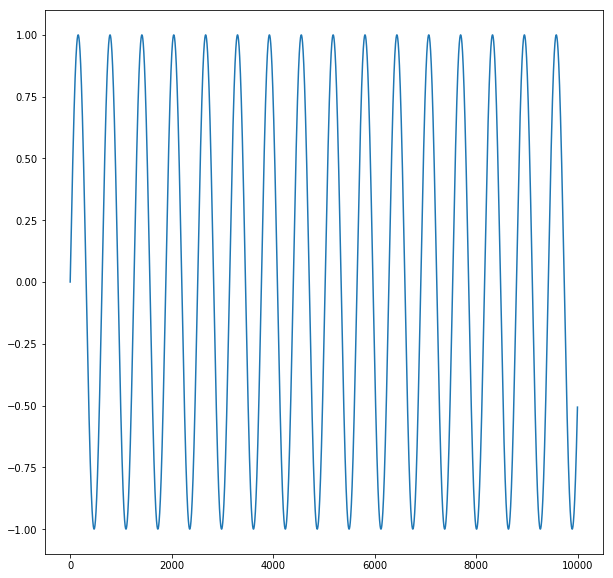

In [39]:
data=[]
for i in np.linspace(0, 100, 10000):
    data += [np.sin(i)]
data = np.array(data)
plt.plot(data)


In [45]:
maxlen=10

X_trn , y_trn  = extract_sequences(data, maxlen=maxlen, step=1)
print(X_trn.shape, y_trn.shape)
print(X_trn[0], y_trn[0])

(9990, 10) (9990,)
[ 0.          0.01000083  0.02000067  0.0299985   0.03999333  0.04998416
  0.05997     0.06994983  0.07992267  0.08988751] 0.0998433676786


In [3]:
# Generated data
#Example dataframe
n_cases = 365*3

data=[]
for i in range(n_cases):
    t = (i/100.)
    s = abs((i%7)-3.5)*2.
    data += list(t + s + np.random.randn(1))

index = pd.date_range('1/1/2000', periods=365*3)
serie = pd.Series(data=data, index=index, name='value')
serie.head


<bound method Series.head of 2000-01-01     5.956137
2000-01-02     5.064229
2000-01-03     1.133512
2000-01-04     0.782403
2000-01-05     0.254580
2000-01-06     3.058781
2000-01-07     5.198209
2000-01-08     8.367264
2000-01-09     6.502491
2000-01-10     3.518903
2000-01-11     1.371413
2000-01-12     1.714192
2000-01-13     2.219399
2000-01-14     5.716181
2000-01-15     4.670269
2000-01-16     4.334262
2000-01-17     4.009900
2000-01-18     1.577604
2000-01-19     1.158924
2000-01-20     3.364035
2000-01-21     5.136995
2000-01-22     6.731127
2000-01-23     4.916504
2000-01-24     4.845334
2000-01-25    -1.731984
2000-01-26     0.625068
2000-01-27     4.117081
2000-01-28     6.315059
2000-01-29     6.273929
2000-01-30     6.081658
                ...    
2002-12-01    17.828343
2002-12-02    12.721339
2002-12-03    11.939833
2002-12-04    12.294202
2002-12-05    12.179105
2002-12-06    16.088383
2002-12-07    17.199161
2002-12-08    15.885909
2002-12-09    11.877556
2002-12-10 

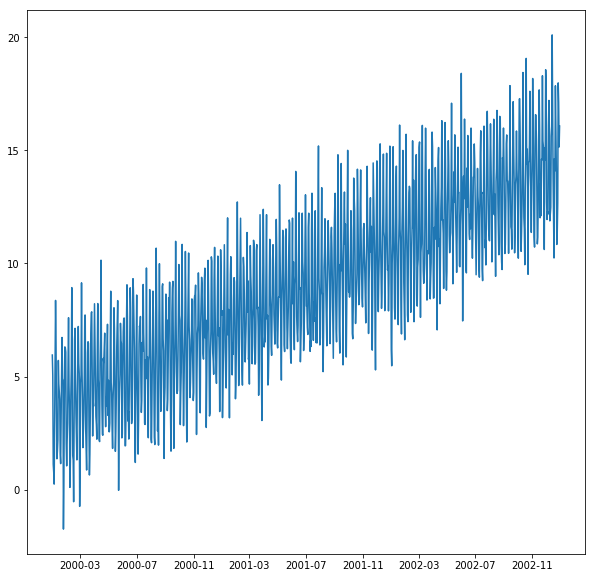

In [4]:
plt.plot(serie)

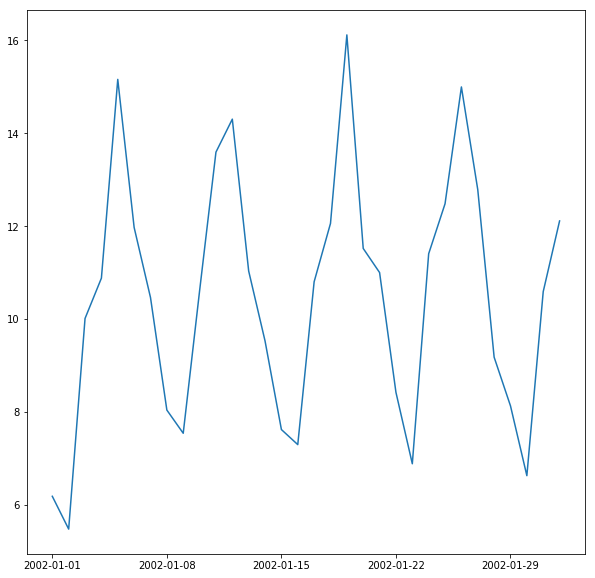

In [5]:
plt.plot(serie['1/1/2002':'2/1/2002'])

In [36]:
def extract_sequences(serie_np, maxlen=14, step=1):
    '''
    Cut the serie in redundant sequences of maxlen data
    One sequence of length 14 for each day
    '''
    sequences = []
    nex_data = []
    for i in range(0, serie_np.shape[0] - maxlen, step): 
        sequences.append(serie_np[i: i + maxlen])
        nex_data.append(serie_np[i + maxlen])
    return np.array(sequences), np.array(nex_data)
#X_trn , y_trn  = extract_sequences(seqs, maxlen=14*24, step=1)

In [73]:
n_weeks = 20

X_trn , y_trn  = extract_sequences(serie.as_matrix(), maxlen=7*n_weeks, step=1)
print(X_trn.shape, y_trn.shape)
print(X_trn[0], y_trn[0])

maxlen=7*n_weeks


(955, 140) (955,)
[  5.95613709   5.06422907   1.13351246   0.78240277   0.25457977
   3.0587807    5.19820892   8.36726352   6.50249104   3.51890273
   1.37141307   1.71419223   2.21939867   5.71618067   4.67026905
   4.33426218   4.00989968   1.57760424   1.15892437   3.3640351
   5.13699507   6.73112742   4.91650445   4.84533376  -1.73198368
   0.62506785   4.1170809    6.3150591    6.2739291    6.08165798
   2.05583144   1.06054042   2.18972111   2.9334033    5.61542629
   7.60390641   4.60014738   3.55599678   0.11034284   1.30037372
   4.1710167    5.38665206   8.93332931   4.87633999   1.52142904
   1.31804317  -0.5250334    3.06548225   6.64439405   7.13526281
   4.86170313   3.34263382   2.21811503   1.32418088   4.19792337
   5.81845854   7.21631011   5.59022043   5.14425885  -0.72859533
   1.61432202   4.73140935   5.08258679   9.14323657   5.33187438
   4.0646219    1.86484669   2.62588302   3.41983656   5.05393195
   7.71092614   7.71989014   2.69251693   1.8042579    0.87

In [41]:
def generate_batch(X, y, batch_size=4, limit=-1):
    ''' 
    Generate batches for one epoch
    Randomize order for each epoch
    '''
    from random import shuffle
    shuffle_index = [i for i in range(0, X.shape[0], batch_size)]
    shuffle(shuffle_index)
    
    for i in shuffle_index[:limit]:
        yield X[i:i+batch_size], y[i:i+batch_size]
        
gb = generate_batch(X_trn, y_trn)

## Basic rnn model over original serie

In [65]:
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))


In [66]:
def dense(x, input_size=10, otput_size=1):
    W = tf.Variable(tf.truncated_normal([input_size, otput_size], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[otput_size]))
    return tf.matmul(x,W) + b

In [74]:
# Parameters

features = 1
lstm_feat = 256

#Inputs
x_input = tf.placeholder(tf.float32, shape=[None, maxlen], name='x')
x_input_lstm = tf.reshape(x_input, [-1,maxlen, 1])
y_input = tf.placeholder(tf.float32, shape=[None], name='y')

# Recurrent layer
lstm1 = tf.nn.rnn_cell.BasicLSTMCell(lstm_feat)
lstm_out, _ = tf.nn.dynamic_rnn(lstm1, x_input_lstm, dtype=tf.float32, scope='lstm091')
print(lstm_out)

#Final dense layer
y_pred  = tf.reshape(dense(lstm_out[:,-1,:], input_size=lstm_feat, otput_size=1),[-1])
print(y_pred)

# Loss function
cost  = tf.reduce_sum(tf.square(y_pred - y_input))

# Trainer
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Tensor("lstm091/transpose:0", shape=(?, 140, 256), dtype=float32)
Tensor("Reshape_13:0", shape=(?,), dtype=float32)


In [75]:
sess.run(tf.global_variables_initializer())

In [78]:
# Train graph
num_epoch=100
batchSize=256
#32468 cases. with batch_size=128 --> 32384 cases used. The last 84 cases (3.5 days) not used in training
i=0
lr=0.003
for epoch in range(num_epoch):
    ce = []
    gb = generate_batch(X_trn, y_trn, batch_size=batchSize)
    for x_b, y_b in gb:
        feed_dict={x_input: x_b, y_input: y_b, learning_rate: lr}
        _, c, prediction, l_out = sess.run([train_step, cost, y_pred, lstm_out], feed_dict=feed_dict)
        ce += [c]
        i += 1
        #if i%100==0:
        #    print( 'Cost:',np.mean(ce, axis=0), ' - Real:',y_b[0], ' - Pred:',prediction[0])
    print('Epoch:', epoch, ' - LR:',lr, ' - Cost:',np.mean(ce, axis=0))
    lr *= 0.99

Epoch: 0  - LR: 0.003  - Cost: 416.054
Epoch: 1  - LR: 0.00297  - Cost: 432.598
Epoch: 2  - LR: 0.0029403  - Cost: 398.408
Epoch: 3  - LR: 0.002910897  - Cost: 377.518
Epoch: 4  - LR: 0.00288178803  - Cost: 407.821
Epoch: 5  - LR: 0.0028529701497  - Cost: 416.561
Epoch: 6  - LR: 0.0028244404482  - Cost: 400.249
Epoch: 7  - LR: 0.00279619604372  - Cost: 386.921
Epoch: 8  - LR: 0.00276823408328  - Cost: 368.92
Epoch: 9  - LR: 0.00274055174245  - Cost: 426.849
Epoch: 10  - LR: 0.00271314622503  - Cost: 390.539
Epoch: 11  - LR: 0.00268601476278  - Cost: 363.295
Epoch: 12  - LR: 0.00265915461515  - Cost: 407.254
Epoch: 13  - LR: 0.002632563069  - Cost: 360.486
Epoch: 14  - LR: 0.00260623743831  - Cost: 401.093
Epoch: 15  - LR: 0.00258017506392  - Cost: 383.419
Epoch: 16  - LR: 0.00255437331328  - Cost: 353.901
Epoch: 17  - LR: 0.00252882958015  - Cost: 349.033
Epoch: 18  - LR: 0.00250354128435  - Cost: 348.665
Epoch: 19  - LR: 0.00247850587151  - Cost: 393.345
Epoch: 20  - LR: 0.00245372081

In [79]:
print('y_trn',y_b[:10])
print('prediction', prediction[:10])

y_trn [  4.74850915   6.48091426   9.98128375  12.71529078   9.28264347
   7.11422985   4.60705021   5.74100974   8.29869843   9.95539341]
prediction [  4.08749866   6.64940882   8.84427643  10.96444702  10.08511829
   7.50800753   5.13304615   4.81787062   7.35870266  10.02988625]
